In [34]:
import json
from itertools import islice
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#https://medium.com/@m_vemuri/create-a-geographic-heat-map-of-the-city-of-toronto-in-python-cd2ae0f8be55
import geopandas as gpd
from geopandas.tools import sjoin
import shapely.geometry

In [13]:
mad_map = gpd.read_file('datasets/acs2021_5yr_B08201_14000US55025011407/acs2021_5yr_B08201_14000US55025011407.geojson')
mad_pop = gpd.read_file('datasets/acs2021_5yr_B01003_14000US55025011407/acs2021_5yr_B01003_14000US55025011407.geojson')
metada = json.load(open('datasets/acs2021_5yr_B08201_14000US55025011407/metadata.json'))

In [14]:
mad_map = mad_map.merge(mad_pop[['name','B01003001']],how='left',on='name')

In [15]:
mad_map['overuse_total']= \
    mad_map['B08201011']+2*mad_map['B08201011']+3*mad_map['B08201012']+ \
    mad_map['B08201017']+2*mad_map['B08201018']+ \
    mad_map['B08201024']
mad_map['pop'] = mad_map['B01003001']
mad_map['overuse_rate'] = mad_map['overuse_total']/mad_map['pop']

<AxesSubplot: >

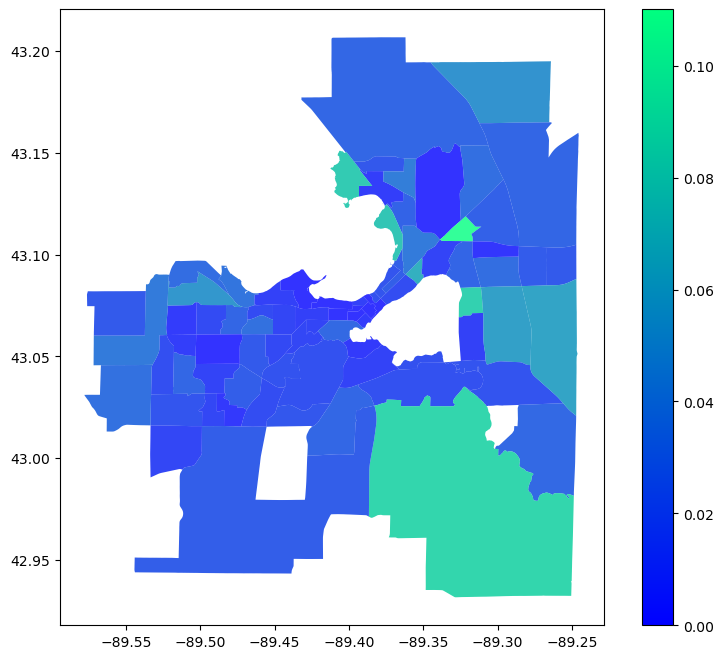

In [16]:
fig, ax = plt.subplots(figsize=(10,8))

mad_map.loc[(mad_map['B08201001']>0) & (mad_map['B08201001']<10000)].plot(column="overuse_rate",ax=ax,alpha=0.8,cmap='winter',legend=True)


In [17]:
metada

{'release': {'id': 'acs2021_5yr',
  'years': '2017-2021',
  'name': 'ACS 2021 5-year'},
 'tables': {'B08201': {'title': 'Household Size by Vehicles Available',
   'universe': 'Households',
   'denominator_column_id': 'B08201001',
   'columns': {'B08201001': {'name': 'Total:', 'indent': 0},
    'B08201002': {'name': 'No vehicle available', 'indent': 1},
    'B08201003': {'name': '1 vehicle available', 'indent': 1},
    'B08201004': {'name': '2 vehicles available', 'indent': 1},
    'B08201005': {'name': '3 vehicles available', 'indent': 1},
    'B08201006': {'name': '4 or more vehicles available', 'indent': 1},
    'B08201007': {'name': '1-person household:', 'indent': 1},
    'B08201008': {'name': 'No vehicle available', 'indent': 2},
    'B08201009': {'name': '1 vehicle available', 'indent': 2},
    'B08201010': {'name': '2 vehicles available', 'indent': 2},
    'B08201011': {'name': '3 vehicles available', 'indent': 2},
    'B08201012': {'name': '4 or more vehicles available', 'inden

In [18]:
mad_trans = gpd.read_file('/Users/willstedden/Downloads/Metro_Transit_Ridership_by_Stop.geojson')

In [8]:
mymap = sjoin(mad_trans,mad_map.loc[(mad_map['B08201001']>0) & (mad_map['B08201001']<10000)], how='left')

In [9]:
map2 = mad_map.merge(mymap.groupby('name')['Weekday'].sum().reset_index(),how='left')

In [10]:
map2['Weekday_normed']=np.log(map2['Weekday']/map2['pop'])

In [19]:
brt = gpd.read_file('datasets/Bus_Rapid_Transit_System_Lines.geojson')
brt.head()

,OBJECTID,Type,Comments,Corridor,Notes,LPA,SHAPESTLength,geometry
0,1,main,None,C,None,3,5884.251504,"LINESTRING (-89.38210 43.07614, -89.38122 43.0..."
1,2,main,None,C,None,1,3292.955598,"LINESTRING (-89.40062 43.07329, -89.40215 43.0..."
2,3,main,None,W,None,1,20640.279196,"LINESTRING (-89.41293 43.07356, -89.41329 43.0..."
3,4,main,None,E,None,1,19033.613315,"LINESTRING (-89.34871 43.10036, -89.34791 43.1..."
4,5,main,None,S,None,2,15851.380171,"LINESTRING (-89.39404 43.03846, -89.39533 43.0..."


<AxesSubplot: >

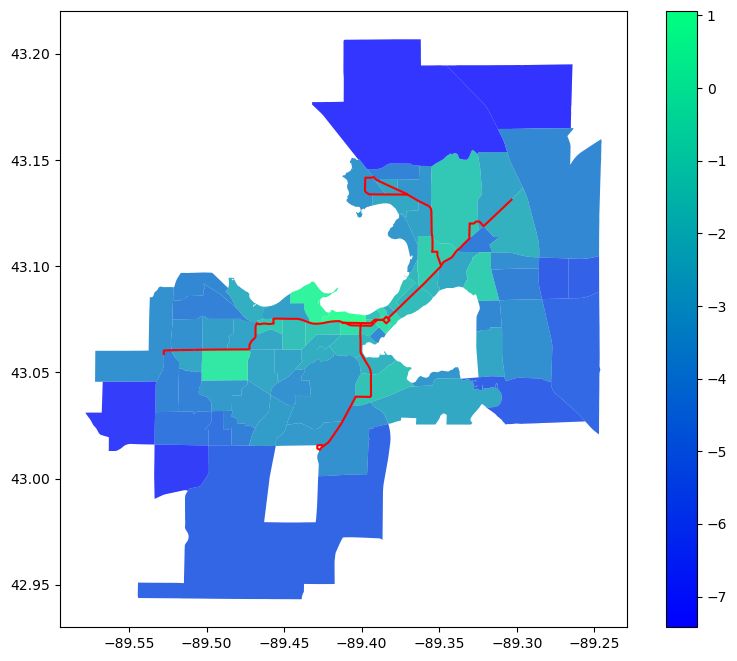

In [20]:
fig, ax = plt.subplots(figsize=(10,8))
map2.plot(column="Weekday_normed",ax=ax,alpha=0.8,cmap='winter',legend=True)
brt.plot(ax=ax,color='red')

In [22]:
zipcar_locs_px = [
    {'left': -18, 'top': -49},
    {'left': -42, 'top': -24},
    {'left': -41, 'top': -4}, 
    {'left': -59, 'top': -15},
    {'left': -76, 'top': -33},
    {'left': -52, 'top': -1},
    {'left': -93, 'top': -13},
    {'left': -94, 'top': -2},
    {'left': -105, 'top': -3},
    {'left': -123, 'top': -35},
    {'left': -83, 'top': 35},
    {'left': -125, 'top': -2},
    {'left': -71, 'top': 51},
    {'left': 86, 'top': -84},
    {'left': -114, 'top': 33}
]

(43.02, 43.12)

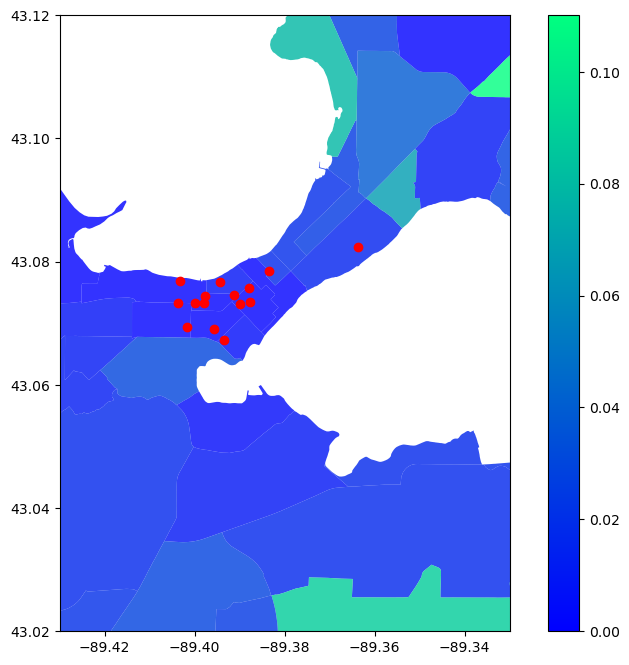

In [73]:
# https://my.zipcar.com/search?_gl=1*wlygnz*_ga*MTk1ODYxMDEzMi4xNjk3OTAyOTA2*_ga_8SY5RP0YRN*MTY5ODY4MjE5OS4zLjEuMTY5ODY4MjY4Ny42MC4wLjA.
range_x, range_y = 0.04,0.015
xs = [z['left'] for z in zipcar_locs_px]
ys = [z['top'] for z in zipcar_locs_px]

trans_x, trans_y, scale_x, scale_y = -89.38,43.073,range_x/abs(max(xs)-min(xs)),range_y/abs(max(ys)-min(ys))
data = [[(trans_x+z['left']*scale_x,trans_y-z['top']*scale_y)] for z in zipcar_locs_px]
df = pd.DataFrame(data, columns=['coordinates'])

gdf = gpd.GeoDataFrame(df, crs="EPSG:4326", geometry=[shapely.geometry.Point(x) for x in df['coordinates']])
gdf = gdf.drop(['coordinates'], axis=1) # drop coordinate tuples, if not needed anymore    
fig, ax = plt.subplots(figsize=(10,8))

mad_map.loc[(mad_map['B08201001']>0) & (mad_map['B08201001']<10000)].plot(column="overuse_rate",ax=ax,alpha=0.8,cmap='winter',legend=True)

gdf.plot(ax=ax,color='red')
plt.xlim([-89.38-0.05,-89.38+0.05])
plt.ylim([43.07-0.05,43.07+0.05])